In [1]:
%run ./Definitions.ipynb
!nvidia-smi
import os

2019-12-20 00:58:33.192956
thunder  Fri Dec 20 00:58:33 2019
[0] GeForce GTX 1080 Ti | 48'C,  24 % | 10895 / 11178 MB | patra(10885M)
[1] GeForce GTX 1080 Ti | 50'C,  23 % | 10895 / 11178 MB | patra(10885M)
[2] GeForce GTX 1080 Ti | 26'C,   0 % | 10895 / 11178 MB | anthoula(10885M)
[3] GeForce GTX 1080 Ti | 26'C,   0 % |    10 / 11178 MB |
[4] GeForce GTX 1080 Ti | 23'C,   0 % |   213 / 11178 MB | srikanth(203M)
[5] GeForce GTX 1080 Ti | 27'C,   0 % |    10 / 11178 MB |
[6] GeForce GTX 1080 Ti | 30'C,   0 % |    10 / 11178 MB |
[7] GeForce GTX 1080 Ti | 28'C,   0 % |    10 / 11178 MB |


/ds/environments/python2020/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.
/ds/environments/python2020/lib/python3.7/site-packages/keras/callbacks/callbacks.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Dataset consist of 85730 patients data with 6251 features for each patient
Function definitions executed
Definitions DONE !!

Fri Dec 20 00:58:45 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 34%   49C    P2    79W / 250W |  10895MiB / 11178MiB |      7%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 35%   48C    P2    56W / 250W |  10895Mi

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "3"   # choose here your GPU (0-7)

import tensorflow as tf
import tensorflow.compat.v1 as tf
import keras
# from keras import backend as K
import tensorflow.python.keras.backend as K

# config = tf.ConfigProto()
# config.gpu_options.allow_growth=True
# sess = tf.Session(config=config)
# K.set_session(sess)

In [3]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

### LOAD valid train test and validation image names 

In [4]:
valid_traindf_names = pd.read_pickle(funduspath_CR + 'valid_traindf_names.pkl')
valid_valdf_names = pd.read_pickle(funduspath_CR + 'valid_valdf_names.pkl')
valid_testdf_names = pd.read_pickle(funduspath_CR + 'valid_testdf_names.pkl')

valid_traindf_names.shape , valid_valdf_names.shape , valid_testdf_names.shape

((101834, 5), (33943, 5), (33936, 5))

In [5]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

## Handling Imbalanced Data sets

In [6]:
which_gt = 4 # CHANGE 1,2,3,4 implies 'GT523', 'GT19', 'GTi', 'GTu'
n_NG = 0 # non glaucoma
n_G = 0  # glaucoma

GT_dict = {1:'GT523',2:'GT19',3:'GTi',4:'GTu'}
Class = GT_dict[which_gt]
temp = valid_traindf_names[Class]
for i in range(len(temp)):
    if(temp[i] == '1'):
        n_G += 1
    else:
        n_NG += 1
        
print("No. of Glaucoma patients in training set:",n_G)
print("No. of non-Glaucoma patients in training set:",n_NG)

No. of Glaucoma patients in training set: 2379
No. of non-Glaucoma patients in training set: 99455


### 1. Over Sampling Train set

In [7]:
# Oversample the minority class

X_train = valid_traindf_names['Fundus_Filenames']
y_train = valid_traindf_names[GT_dict[which_gt]]

# Converting class values to int 1 or 0
y_train = y_train.astype(int)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_glaucoma = X[X[Class]==0]
glaucoma = X[X[Class]==1]

# upsample minority
glaucoma_upsampled = resample(glaucoma,
                              replace=True, # sample with replacement
                              n_samples=len(not_glaucoma), # match number in majority class
                              random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_glaucoma,glaucoma_upsampled])

# shuffle upsampled dataframe for training
upsampled = upsampled.sample(frac=1)


In [8]:
X[Class].value_counts()

0    99455
1     2379
Name: GTu, dtype: int64

In [9]:
upsampled[Class].value_counts()

1    99455
0    99455
Name: GTu, dtype: int64

#### validation distribution

In [10]:
valid_valdf_names[Class].value_counts()

0    33134
1      809
Name: GTu, dtype: int64

### Oversampling minority with less imbalance - in train set
Original imbalance ratio **X-** 1:40

Imbalance ratio **up1**-1:5, **up2**-1:10, **up3**-1:20, **up4**-1:30

Balanced ratio **upsampled**-1:1

In [11]:
# upsampling minority
glaucoma_up1 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/5), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up2 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/10), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up3 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/20), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up4 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/30), # match number in majority class
                        random_state=42) # reproducible results

# combine majority and upsampled minority
up1 = pd.concat([not_glaucoma,glaucoma_up1])
up2 = pd.concat([not_glaucoma,glaucoma_up2])
up3 = pd.concat([not_glaucoma,glaucoma_up3])
up4 = pd.concat([not_glaucoma,glaucoma_up4])

# shuffle upsampled dataframe for training
up1 = up1.sample(frac=1)
up2 = up2.sample(frac=1)
up3 = up3.sample(frac=1)
up4 = up4.sample(frac=1)


In [12]:
print("up1")
print(up1[Class].value_counts())
print("up2")
print(up2[Class].value_counts())
print("up1")
print(up3[Class].value_counts())
print("up4")
print(up4[Class].value_counts())

up1
0    99455
1    19891
Name: GTu, dtype: int64
up2
0    99455
1     9945
Name: GTu, dtype: int64
up1
0    99455
1     4972
Name: GTu, dtype: int64
up4
0    99455
1     3315
Name: GTu, dtype: int64


### 2. Class weight

In [13]:
# # Setting class weight for retraining:

# # compute_class_weight('balanced', np.unique(y_train), y_train)
# class_weight = [0.5, 2] # experiment with different values
n_NG , n_G

(99455, 2379)

## Define Model and Metrics

In [14]:
# reg_values = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6] # 1e-1, 
reg_value = 0.001
METRICS = [keras.metrics.BinaryAccuracy(name='Accuracy'),
           Precision, 
           Recall, 
           F1,
           keras.metrics.AUC(name='AUC')]

def mobilenet_model():       
    mobile_conv = MobileNet(weights='imagenet', include_top=False, input_shape=(red_size, red_size, 3))

    # UnFreeze last conv layer
    for layer in mobile_conv.layers[:78]:
        layer.trainable = False
    for layer in mobile_conv.layers[78:]:
        layer.trainable = True
        
    # Create the model
    model = models.Sequential()
    model.add(mobile_conv)
 
    # Add new layers
    # https://adventuresinmachinelearning.com/global-average-pooling-convolutional-neural-networks/
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1, activation='sigmoid'))
 
    return model

### Augmentation
https://nbviewer.jupyter.org/github/aleju/imgaug-doc/blob/master/notebooks/A01%20-%20Load%20and%20Augment%20an%20Image.ipynb

In [15]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(scale=1.1),
    iaa.Affine(rotate=(-10, 10)),
    # iaa.GammaContrast(0.9),
    iaa.Resize({"height": 230, "width": 230}),
    iaa.CropToFixedSize(width=red_size, height=red_size)
    ])

### Flow from Dataframe
https://www.kaggle.com/dmitrypukhov/cnn-with-imagedatagenerator-flow-from-dataframe

In [16]:
# To use same settings as mobilenet
# from keras.applications.mobilenet import preprocess_input
# train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

train_datagen = ImageDataGenerator(preprocessing_function=seq.augment_image, samplewise_center=True, rescale= 1./255) 
val_datagen = ImageDataGenerator(samplewise_center=True, rescale=1./255)  
BATCH_SIZE = 32

print("\nOriginal imbalanced train data: ")
imb_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = valid_traindf_names, # imbalanced train dataframe
    directory=trainpath,
    x_col=valid_traindf_names.columns[0],
    y_col=valid_traindf_names.columns[which_gt],
#     x_col = upsampled.columns[0], # upsampled data
#     y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nOriginal validation data: ")
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=valid_valdf_names,
    directory=valpath,
    x_col=valid_valdf_names.columns[0],
    y_col=valid_valdf_names.columns[which_gt],
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUpsampled train data 1:1 ")
up_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = upsampled, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = upsampled.columns[0], # upsampled data
    y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP1 train data 1:5 ")
up1_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up1, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up1.columns[0], # upsampled data
    y_col = up1.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP2 train data 1:10 ")
up2_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up2, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up2.columns[0], # upsampled data
    y_col = up2.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP3 train data 1:20 ")
up3_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up3, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up3.columns[0], # upsampled data
    y_col = up3.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP4 train data 1:30 ")
up4_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up4, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up4.columns[0], # upsampled data
    y_col = up4.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)



Original imbalanced train data: 
Found 101834 validated image filenames.

Original validation data: 
Found 33943 validated image filenames.

Upsampled train data 1:1 
Found 198910 validated image filenames.

UP1 train data 1:5 
Found 119346 validated image filenames.

UP2 train data 1:10 
Found 109400 validated image filenames.

UP3 train data 1:20 
Found 104427 validated image filenames.

UP4 train data 1:30 
Found 102770 validated image filenames.


### Choosing parameters and model compile

In [17]:
which_model = mobilenet_model
# which_model = vgg_model

model = which_model()
learning_rate  = 0.0001 
decay = 1e-5
momentum=0.9
opt = Adam(lr=learning_rate, decay = decay) 
model.compile(loss='binary_crossentropy', metrics=METRICS, optimizer=opt)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 3,229,889
Trainable params: 1,589,249
Non-trainable params: 1,640,640
_________________________________________________________________


In [18]:
# With L2 weight regularizer
# es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.000001, verbose=1)
n_epochs=200
n_steps_per_epoch = 50
n_validation_steps = 10

### Train with upsampled data (1:1)

In [19]:
start = time.time()
up_history = model.fit_generator(up_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              callbacks=[reduce_lr]
                             )
end = time.time()

/ds/environments/python2020/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(values, collections.Sequence):


Epoch 1/200
50/50 [==============================] - 24s 488ms/step - loss: 0.7329 - Accuracy: 0.5700 - Precision: 0.5931 - Recall: 0.5390 - F1: 0.5397 - AUC: 0.6039 - val_loss: 1.1355 - val_Accuracy: 0.3219 - val_Precision: 0.0407 - val_Recall: 0.5500 - val_F1: 0.0744 - val_AUC: 0.7445
Epoch 2/200
50/50 [==============================] - 22s 442ms/step - loss: 0.6814 - Accuracy: 0.6100 - Precision: 0.6100 - Recall: 0.6192 - F1: 0.6079 - AUC: 0.6472 - val_loss: 1.5166 - val_Accuracy: 0.0719 - val_Precision: 0.0418 - val_Recall: 0.9000 - val_F1: 0.0795 - val_AUC: 0.5193
Epoch 3/200
50/50 [==============================] - 24s 472ms/step - loss: 0.6789 - Accuracy: 0.6087 - Precision: 0.6205 - Recall: 0.5805 - F1: 0.5913 - AUC: 0.6488 - val_loss: 1.4390 - val_Accuracy: 0.1031 - val_Precision: 0.0138 - val_Recall: 0.4000 - val_F1: 0.0267 - val_AUC: 0.6839
Epoch 4/200
50/50 [==============================] - 23s 461ms/step - loss: 0.6480 - Accuracy: 0.6300 - Precision: 0.6290 - Recall: 0.67

Epoch 29/200
50/50 [==============================] - 24s 481ms/step - loss: 0.5265 - Accuracy: 0.7350 - Precision: 0.7257 - Recall: 0.7555 - F1: 0.7302 - AUC: 0.8148 - val_loss: 0.9709 - val_Accuracy: 0.2438 - val_Precision: 0.0115 - val_Recall: 0.2500 - val_F1: 0.0220 - val_AUC: 0.5103
Epoch 30/200
50/50 [==============================] - 23s 466ms/step - loss: 0.5319 - Accuracy: 0.7394 - Precision: 0.7300 - Recall: 0.7844 - F1: 0.7501 - AUC: 0.8103 - val_loss: 0.9757 - val_Accuracy: 0.2812 - val_Precision: 0.0421 - val_Recall: 0.7500 - val_F1: 0.0792 - val_AUC: 0.5123
Epoch 31/200
50/50 [==============================] - 24s 479ms/step - loss: 0.5315 - Accuracy: 0.7419 - Precision: 0.7333 - Recall: 0.7760 - F1: 0.7480 - AUC: 0.8145 - val_loss: 1.2814 - val_Accuracy: 0.1813 - val_Precision: 0.0507 - val_Recall: 0.8000 - val_F1: 0.0945 - val_AUC: 0.6277
Epoch 32/200
50/50 [==============================] - 23s 462ms/step - loss: 0.5260 - Accuracy: 0.7350 - Precision: 0.7155 - Recall: 

50/50 [==============================] - 24s 481ms/step - loss: 0.5227 - Accuracy: 0.7444 - Precision: 0.7343 - Recall: 0.7712 - F1: 0.7469 - AUC: 0.8212 - val_loss: 1.2326 - val_Accuracy: 0.2250 - val_Precision: 0.0201 - val_Recall: 0.4000 - val_F1: 0.0380 - val_AUC: 0.5929
Epoch 58/200
50/50 [==============================] - 23s 459ms/step - loss: 0.5193 - Accuracy: 0.7425 - Precision: 0.7092 - Recall: 0.7775 - F1: 0.7343 - AUC: 0.8234 - val_loss: 1.2226 - val_Accuracy: 0.2250 - val_Precision: 0.0075 - val_Recall: 0.2000 - val_F1: 0.0146 - val_AUC: 0.7303
Epoch 59/200
50/50 [==============================] - 24s 487ms/step - loss: 0.5274 - Accuracy: 0.7262 - Precision: 0.7387 - Recall: 0.7493 - F1: 0.7376 - AUC: 0.8116 - val_loss: 1.2458 - val_Accuracy: 0.2313 - val_Precision: 0.0234 - val_Recall: 0.4000 - val_F1: 0.0440 - val_AUC: 0.5735
Epoch 60/200
50/50 [==============================] - 23s 457ms/step - loss: 0.5227 - Accuracy: 0.7306 - Precision: 0.7199 - Recall: 0.7624 - F1: 

50/50 [==============================] - 24s 476ms/step - loss: 0.5517 - Accuracy: 0.7056 - Precision: 0.7049 - Recall: 0.7388 - F1: 0.7106 - AUC: 0.7881 - val_loss: 1.1443 - val_Accuracy: 0.2156 - val_Precision: 0.0394 - val_Recall: 0.6000 - val_F1: 0.0726 - val_AUC: 0.5595
Epoch 86/200
50/50 [==============================] - 23s 459ms/step - loss: 0.5332 - Accuracy: 0.7381 - Precision: 0.7330 - Recall: 0.7557 - F1: 0.7382 - AUC: 0.8071 - val_loss: 1.2317 - val_Accuracy: 0.2000 - val_Precision: 0.0420 - val_Recall: 0.6000 - val_F1: 0.0759 - val_AUC: 0.6021
Epoch 87/200
50/50 [==============================] - 23s 466ms/step - loss: 0.5250 - Accuracy: 0.7481 - Precision: 0.7515 - Recall: 0.7601 - F1: 0.7500 - AUC: 0.8194 - val_loss: 1.2713 - val_Accuracy: 0.1937 - val_Precision: 0.0255 - val_Recall: 0.5000 - val_F1: 0.0482 - val_AUC: 0.6773
Epoch 88/200
50/50 [==============================] - 24s 480ms/step - loss: 0.5043 - Accuracy: 0.7606 - Precision: 0.7493 - Recall: 0.7816 - F1: 

50/50 [==============================] - 24s 481ms/step - loss: 0.5370 - Accuracy: 0.7350 - Precision: 0.7113 - Recall: 0.7715 - F1: 0.7355 - AUC: 0.8089 - val_loss: 1.2974 - val_Accuracy: 0.2062 - val_Precision: 0.0418 - val_Recall: 0.7000 - val_F1: 0.0781 - val_AUC: 0.6586
Epoch 114/200
50/50 [==============================] - 23s 462ms/step - loss: 0.5208 - Accuracy: 0.7394 - Precision: 0.7147 - Recall: 0.7732 - F1: 0.7353 - AUC: 0.8209 - val_loss: 1.3246 - val_Accuracy: 0.2344 - val_Precision: 0.0078 - val_Recall: 0.2000 - val_F1: 0.0151 - val_AUC: 0.7083
Epoch 115/200
50/50 [==============================] - 23s 465ms/step - loss: 0.5403 - Accuracy: 0.7437 - Precision: 0.7396 - Recall: 0.7704 - F1: 0.7483 - AUC: 0.8054 - val_loss: 1.2321 - val_Accuracy: 0.1906 - val_Precision: 0.0289 - val_Recall: 0.4000 - val_F1: 0.0530 - val_AUC: 0.7025
Epoch 116/200
50/50 [==============================] - 24s 482ms/step - loss: 0.5128 - Accuracy: 0.7631 - Precision: 0.7717 - Recall: 0.7889 - F

50/50 [==============================] - 23s 460ms/step - loss: 0.5227 - Accuracy: 0.7356 - Precision: 0.7260 - Recall: 0.7724 - F1: 0.7398 - AUC: 0.8184 - val_loss: 1.1518 - val_Accuracy: 0.1937 - val_Precision: 0.0295 - val_Recall: 0.6000 - val_F1: 0.0560 - val_AUC: 0.5907
Epoch 142/200
50/50 [==============================] - 24s 479ms/step - loss: 0.5115 - Accuracy: 0.7556 - Precision: 0.7530 - Recall: 0.7766 - F1: 0.7557 - AUC: 0.8316 - val_loss: 1.3518 - val_Accuracy: 0.2344 - val_Precision: 0.0228 - val_Recall: 0.5000 - val_F1: 0.0434 - val_AUC: 0.6155
Epoch 143/200
50/50 [==============================] - 23s 456ms/step - loss: 0.5126 - Accuracy: 0.7569 - Precision: 0.7356 - Recall: 0.8030 - F1: 0.7623 - AUC: 0.8334 - val_loss: 1.0849 - val_Accuracy: 0.2219 - val_Precision: 0.0352 - val_Recall: 0.6500 - val_F1: 0.0664 - val_AUC: 0.6516
Epoch 144/200
50/50 [==============================] - 23s 459ms/step - loss: 0.5213 - Accuracy: 0.7431 - Precision: 0.7411 - Recall: 0.7565 - F

50/50 [==============================] - 23s 455ms/step - loss: 0.5137 - Accuracy: 0.7487 - Precision: 0.7492 - Recall: 0.7649 - F1: 0.7509 - AUC: 0.8286 - val_loss: 1.3540 - val_Accuracy: 0.2219 - val_Precision: 0.0299 - val_Recall: 0.5000 - val_F1: 0.0558 - val_AUC: 0.6629
Epoch 170/200
50/50 [==============================] - 24s 477ms/step - loss: 0.5182 - Accuracy: 0.7613 - Precision: 0.7569 - Recall: 0.7810 - F1: 0.7619 - AUC: 0.8252 - val_loss: 1.4503 - val_Accuracy: 0.2219 - val_Precision: 0.0362 - val_Recall: 0.5000 - val_F1: 0.0665 - val_AUC: 0.7613
Epoch 171/200
50/50 [==============================] - 23s 452ms/step - loss: 0.5161 - Accuracy: 0.7462 - Precision: 0.7252 - Recall: 0.7691 - F1: 0.7403 - AUC: 0.8280 - val_loss: 1.2310 - val_Accuracy: 0.2219 - val_Precision: 0.0307 - val_Recall: 0.5167 - val_F1: 0.0572 - val_AUC: 0.5852
Epoch 172/200
50/50 [==============================] - 23s 451ms/step - loss: 0.5155 - Accuracy: 0.7456 - Precision: 0.7269 - Recall: 0.7775 - F

50/50 [==============================] - 23s 464ms/step - loss: 0.5186 - Accuracy: 0.7550 - Precision: 0.7351 - Recall: 0.7896 - F1: 0.7569 - AUC: 0.8267 - val_loss: 1.2699 - val_Accuracy: 0.2313 - val_Precision: 0.0316 - val_Recall: 0.3500 - val_F1: 0.0578 - val_AUC: 0.5606
Epoch 198/200
50/50 [==============================] - 22s 450ms/step - loss: 0.5079 - Accuracy: 0.7550 - Precision: 0.7307 - Recall: 0.7953 - F1: 0.7556 - AUC: 0.8378 - val_loss: 1.2624 - val_Accuracy: 0.1750 - val_Precision: 0.0106 - val_Recall: 0.3000 - val_F1: 0.0205 - val_AUC: 0.8996
Epoch 199/200
50/50 [==============================] - 24s 475ms/step - loss: 0.5033 - Accuracy: 0.7462 - Precision: 0.7337 - Recall: 0.7803 - F1: 0.7512 - AUC: 0.8372 - val_loss: 1.2753 - val_Accuracy: 0.1625 - val_Precision: 0.0149 - val_Recall: 0.3000 - val_F1: 0.0282 - val_AUC: 0.5298
Epoch 200/200
50/50 [==============================] - 22s 446ms/step - loss: 0.5113 - Accuracy: 0.7525 - Precision: 0.7557 - Recall: 0.7739 - F

In [20]:
print("Time taken:",end-start)

Time taken: 4655.590343236923


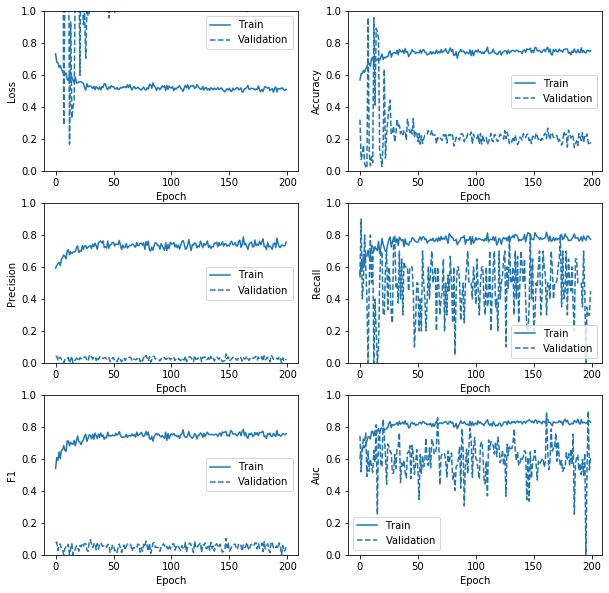

In [21]:
plt.figure(figsize=(10,10))
plot_metrics(up_history)

### Train with UP2 (1:10)

In [22]:
# start = time.time()
# up2_history = model.fit_generator(up2_train_generator, 
#                               epochs=n_epochs, 
#                               steps_per_epoch=n_steps_per_epoch,
#                               validation_data=validation_generator,
#                               validation_steps=n_validation_steps,
#                               class_weight = [1.5,0.5],
#                               callbacks=[reduce_lr]
#                              )
# end = time.time()

In [23]:
# print("Time taken:",end-start)

In [24]:
# plt.figure(figsize=(10,10))
# plot_metrics(up2_history)

### Train with UP3 (1:20)

In [25]:
start = time.time()
up3_history = model.fit_generator(up3_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              class_weight = [0.5,3],
                              callbacks=[reduce_lr]
                             )
end = time.time()

Epoch 1/200
50/50 [==============================] - 21s 425ms/step - loss: 0.7106 - Accuracy: 0.5763 - Precision: 0.0951 - Recall: 0.7683 - F1: 0.1637 - AUC: 0.8278 - val_loss: 1.3818 - val_Accuracy: 0.2000 - val_Precision: 0.0223 - val_Recall: 0.5000 - val_F1: 0.0425 - val_AUC: 0.7086
Epoch 2/200
50/50 [==============================] - 21s 428ms/step - loss: 0.6602 - Accuracy: 0.6225 - Precision: 0.1034 - Recall: 0.7600 - F1: 0.1766 - AUC: 0.8606 - val_loss: 1.1989 - val_Accuracy: 0.1344 - val_Precision: 0.0244 - val_Recall: 0.6000 - val_F1: 0.0468 - val_AUC: 0.5575
Epoch 3/200
50/50 [==============================] - 21s 413ms/step - loss: 0.6291 - Accuracy: 0.6519 - Precision: 0.1206 - Recall: 0.6777 - F1: 0.1980 - AUC: 0.8255 - val_loss: 1.2029 - val_Accuracy: 0.1500 - val_Precision: 0.0143 - val_Recall: 0.3000 - val_F1: 0.0272 - val_AUC: 0.3435
Epoch 4/200
50/50 [==============================] - 21s 411ms/step - loss: 0.5939 - Accuracy: 0.6569 - Precision: 0.1080 - Recall: 0.65

50/50 [==============================] - 20s 400ms/step - loss: 0.2994 - Accuracy: 0.9244 - Precision: 0.2700 - Recall: 0.2900 - F1: 0.2571 - AUC: 0.8448 - val_loss: 1.0204 - val_Accuracy: 0.3500 - val_Precision: 0.0403 - val_Recall: 0.5500 - val_F1: 0.0733 - val_AUC: 0.6134
Epoch 30/200
50/50 [==============================] - 20s 400ms/step - loss: 0.2882 - Accuracy: 0.9256 - Precision: 0.2433 - Recall: 0.2607 - F1: 0.2286 - AUC: 0.8737 - val_loss: 0.9058 - val_Accuracy: 0.3250 - val_Precision: 0.0181 - val_Recall: 0.2500 - val_F1: 0.0334 - val_AUC: 0.5807
Epoch 31/200
50/50 [==============================] - 21s 415ms/step - loss: 0.2911 - Accuracy: 0.9250 - Precision: 0.2357 - Recall: 0.2717 - F1: 0.2204 - AUC: 0.8181 - val_loss: 0.7869 - val_Accuracy: 0.3812 - val_Precision: 0.0383 - val_Recall: 0.6667 - val_F1: 0.0714 - val_AUC: 0.6008
Epoch 32/200
50/50 [==============================] - 20s 396ms/step - loss: 0.2907 - Accuracy: 0.9212 - Precision: 0.1829 - Recall: 0.2567 - F1: 

50/50 [==============================] - 21s 417ms/step - loss: 0.2115 - Accuracy: 0.9494 - Precision: 0.0700 - Recall: 0.0317 - F1: 0.0433 - AUC: 0.8131 - val_loss: 0.7256 - val_Accuracy: 0.6406 - val_Precision: 0.0241 - val_Recall: 0.2000 - val_F1: 0.0427 - val_AUC: 0.6287
Epoch 58/200
50/50 [==============================] - 21s 414ms/step - loss: 0.2060 - Accuracy: 0.9488 - Precision: 0.1000 - Recall: 0.0650 - F1: 0.0747 - AUC: 0.8518 - val_loss: 0.7046 - val_Accuracy: 0.5969 - val_Precision: 0.0177 - val_Recall: 0.1500 - val_F1: 0.0310 - val_AUC: 0.4682
Epoch 59/200
50/50 [==============================] - 20s 400ms/step - loss: 0.1973 - Accuracy: 0.9569 - Precision: 0.1800 - Recall: 0.1067 - F1: 0.1300 - AUC: 0.8317 - val_loss: 0.6479 - val_Accuracy: 0.5969 - val_Precision: 0.0300 - val_Recall: 0.1667 - val_F1: 0.0502 - val_AUC: 0.5721
Epoch 60/200
50/50 [==============================] - 20s 405ms/step - loss: 0.2159 - Accuracy: 0.9481 - Precision: 0.1000 - Recall: 0.0483 - F1: 

50/50 [==============================] - 20s 408ms/step - loss: 0.1677 - Accuracy: 0.9588 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8119 - val_loss: 0.5757 - val_Accuracy: 0.7937 - val_Precision: 0.0310 - val_Recall: 0.2000 - val_F1: 0.0536 - val_AUC: 0.5485
Epoch 86/200
50/50 [==============================] - 20s 406ms/step - loss: 0.1768 - Accuracy: 0.9531 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8028 - val_loss: 0.5471 - val_Accuracy: 0.7594 - val_Precision: 0.0333 - val_Recall: 0.1333 - val_F1: 0.0508 - val_AUC: 0.5304
Epoch 87/200
50/50 [==============================] - 21s 422ms/step - loss: 0.1794 - Accuracy: 0.9538 - Precision: 0.0200 - Recall: 0.0200 - F1: 0.0200 - AUC: 0.7882 - val_loss: 0.4831 - val_Accuracy: 0.7875 - val_Precision: 0.0634 - val_Recall: 0.3000 - val_F1: 0.0988 - val_AUC: 0.6951
Epoch 88/200
50/50 [==============================] - 20s 404ms/step - loss: 0.1692 - Accuracy: 0.9581 - Precision: 0.0400

Epoch 113/200
50/50 [==============================] - 21s 411ms/step - loss: 0.1651 - Accuracy: 0.9500 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8451 - val_loss: 0.4921 - val_Accuracy: 0.8406 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4537
Epoch 114/200
50/50 [==============================] - 20s 407ms/step - loss: 0.1713 - Accuracy: 0.9450 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8562 - val_loss: 0.3845 - val_Accuracy: 0.8875 - val_Precision: 0.0750 - val_Recall: 0.2500 - val_F1: 0.1119 - val_AUC: 0.5826
Epoch 115/200
50/50 [==============================] - 20s 393ms/step - loss: 0.1708 - Accuracy: 0.9488 - Precision: 0.0200 - Recall: 0.0200 - F1: 0.0200 - AUC: 0.8359 - val_loss: 0.3657 - val_Accuracy: 0.9062 - val_Precision: 0.0867 - val_Recall: 0.1583 - val_F1: 0.0952 - val_AUC: 0.7887
Epoch 116/200
50/50 [==============================] - 21s 411ms/step - loss: 0.1413 - Accurac

50/50 [==============================] - 28s 551ms/step - loss: 0.1396 - Accuracy: 0.9619 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8254 - val_loss: 0.5037 - val_Accuracy: 0.8750 - val_Precision: 0.0333 - val_Recall: 0.1000 - val_F1: 0.0500 - val_AUC: 0.5557
Epoch 141/200
50/50 [==============================] - 29s 580ms/step - loss: 0.1441 - Accuracy: 0.9563 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8552 - val_loss: 0.3487 - val_Accuracy: 0.8906 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6058
Epoch 142/200
50/50 [==============================] - 28s 570ms/step - loss: 0.1722 - Accuracy: 0.9450 - Precision: 0.0200 - Recall: 0.0100 - F1: 0.0133 - AUC: 0.8570 - val_loss: 0.3515 - val_Accuracy: 0.9125 - val_Precision: 0.0500 - val_Recall: 0.1000 - val_F1: 0.0667 - val_AUC: 0.6995
Epoch 143/200
50/50 [==============================] - 30s 609ms/step - loss: 0.1511 - Accuracy: 0.9569 - Pr

50/50 [==============================] - 26s 516ms/step - loss: 0.1641 - Accuracy: 0.9488 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8241 - val_loss: 0.2847 - val_Accuracy: 0.9500 - val_Precision: 0.1000 - val_Recall: 0.1000 - val_F1: 0.1000 - val_AUC: 0.7489
Epoch 168/200
50/50 [==============================] - 26s 520ms/step - loss: 0.1524 - Accuracy: 0.9569 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8053 - val_loss: 0.3484 - val_Accuracy: 0.9563 - val_Precision: 0.0500 - val_Recall: 0.1000 - val_F1: 0.0667 - val_AUC: 0.6898
Epoch 169/200
50/50 [==============================] - 25s 502ms/step - loss: 0.1492 - Accuracy: 0.9569 - Precision: 0.0200 - Recall: 0.0200 - F1: 0.0200 - AUC: 0.8398 - val_loss: 0.2977 - val_Accuracy: 0.9438 - val_Precision: 0.0333 - val_Recall: 0.0500 - val_F1: 0.0400 - val_AUC: 0.6629
Epoch 170/200
50/50 [==============================] - 24s 478ms/step - loss: 0.1481 - Accuracy: 0.9581 - Precision: 0.0

Epoch 194/200
50/50 [==============================] - 22s 441ms/step - loss: 0.1558 - Accuracy: 0.9531 - Precision: 0.0200 - Recall: 0.0200 - F1: 0.0200 - AUC: 0.8383 - val_loss: 0.2433 - val_Accuracy: 0.9469 - val_Precision: 0.1000 - val_Recall: 0.1000 - val_F1: 0.1000 - val_AUC: 0.7192
Epoch 195/200
50/50 [==============================] - 22s 435ms/step - loss: 0.1561 - Accuracy: 0.9519 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8439 - val_loss: 0.3336 - val_Accuracy: 0.9312 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6324
Epoch 196/200
50/50 [==============================] - 21s 418ms/step - loss: 0.1583 - Accuracy: 0.9506 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8417 - val_loss: 0.3448 - val_Accuracy: 0.9250 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6241
Epoch 197/200
50/50 [==============================] - 21s 415ms/step - loss: 0.15

In [26]:
print("Time taken:",end-start)

Time taken: 4420.055287122726


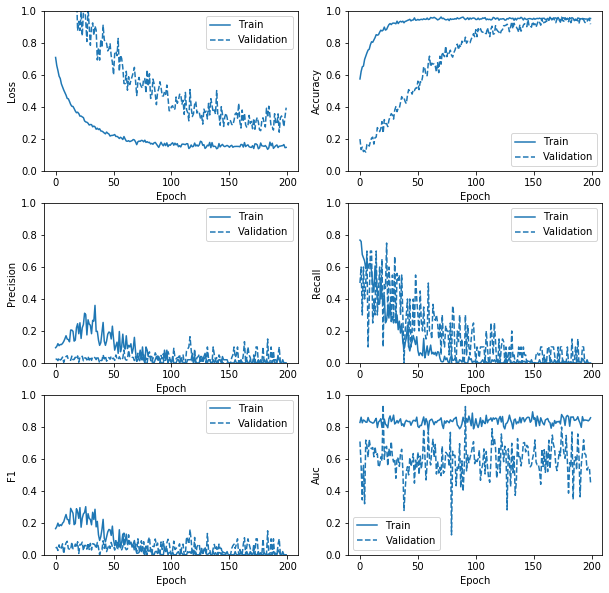

In [27]:
plt.figure(figsize=(10,10))
plot_metrics(up3_history)

### Train with UP4 (1:30)

In [28]:
# start = time.time()
# up4_history = model.fit_generator(up4_train_generator, 
#                               epochs=n_epochs, 
#                               steps_per_epoch=n_steps_per_epoch,
#                               validation_data=validation_generator,
#                               validation_steps=n_validation_steps, 
#                               callbacks=[reduce_lr]
#                              )
# end = time.time()

In [29]:
# print("Time taken:",end-start)

In [30]:
# plt.figure(figsize=(10,10))
# plot_metrics(up4_history)

### Train with Imbalanced original train data (1:40)

In [31]:
start = time.time()
imb_history = model.fit_generator(imb_train_generator,
                                  epochs=n_epochs,
                                  steps_per_epoch=n_steps_per_epoch,
                                  validation_data=validation_generator,
                                  validation_steps=n_validation_steps,
                                  class_weight = [0.2,5],
                                  callbacks=[reduce_lr]
                                 )
end = time.time()

Epoch 1/200
50/50 [==============================] - 22s 431ms/step - loss: 0.1128 - Accuracy: 0.9712 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8414 - val_loss: 0.3148 - val_Accuracy: 0.9656 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5867
Epoch 2/200
50/50 [==============================] - 21s 414ms/step - loss: 0.0906 - Accuracy: 0.9812 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8502 - val_loss: 0.2764 - val_Accuracy: 0.9500 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6819
Epoch 3/200
50/50 [==============================] - 21s 430ms/step - loss: 0.1037 - Accuracy: 0.9762 - Precision: 0.0200 - Recall: 0.0100 - F1: 0.0133 - AUC: 0.8457 - val_loss: 0.3455 - val_Accuracy: 0.9438 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5712
Epoch 4/200
50/50 [==============================] - 20s 401ms/step - loss: 

50/50 [==============================] - 21s 420ms/step - loss: 0.0920 - Accuracy: 0.9775 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8444 - val_loss: 0.2025 - val_Accuracy: 0.9656 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4887
Epoch 28/200
50/50 [==============================] - 20s 398ms/step - loss: 0.0979 - Accuracy: 0.9769 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8186 - val_loss: 0.1926 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6197
Epoch 29/200
50/50 [==============================] - 20s 407ms/step - loss: 0.0885 - Accuracy: 0.9787 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8673 - val_loss: 0.2384 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.3657
Epoch 30/200
50/50 [==============================] - 20s 391ms/step - los

50/50 [==============================] - 20s 398ms/step - loss: 0.0954 - Accuracy: 0.9769 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7926 - val_loss: 0.2214 - val_Accuracy: 0.9750 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6188
Epoch 54/200
50/50 [==============================] - 21s 415ms/step - loss: 0.0860 - Accuracy: 0.9806 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8093 - val_loss: 0.2943 - val_Accuracy: 0.9719 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5843
Epoch 55/200
50/50 [==============================] - 19s 385ms/step - loss: 0.0910 - Accuracy: 0.9781 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8332 - val_loss: 0.2210 - val_Accuracy: 0.9750 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6014
Epoch 56/200
50/50 [==============================] - 20s 405ms/step - los

50/50 [==============================] - 20s 395ms/step - loss: 0.0952 - Accuracy: 0.9762 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8500 - val_loss: 0.2344 - val_Accuracy: 0.9812 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.3997
Epoch 80/200
50/50 [==============================] - 21s 418ms/step - loss: 0.0963 - Accuracy: 0.9756 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8270 - val_loss: 0.1720 - val_Accuracy: 0.9875 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6353
Epoch 81/200
50/50 [==============================] - 20s 406ms/step - loss: 0.1117 - Accuracy: 0.9694 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8595 - val_loss: 0.1712 - val_Accuracy: 0.9812 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6064
Epoch 82/200
50/50 [==============================] - 20s 408ms/step - los

50/50 [==============================] - 20s 392ms/step - loss: 0.0926 - Accuracy: 0.9781 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7888 - val_loss: 0.2032 - val_Accuracy: 0.9844 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7044
Epoch 106/200
50/50 [==============================] - 20s 395ms/step - loss: 0.0929 - Accuracy: 0.9769 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8531 - val_loss: 0.1445 - val_Accuracy: 0.9875 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5890
Epoch 107/200
50/50 [==============================] - 23s 457ms/step - loss: 0.1083 - Accuracy: 0.9700 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8682 - val_loss: 0.1941 - val_Accuracy: 0.9743 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7013
Epoch 108/200
50/50 [==============================] - 17s 345ms/step - 

50/50 [==============================] - 21s 428ms/step - loss: 0.0899 - Accuracy: 0.9775 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8534 - val_loss: 0.1805 - val_Accuracy: 0.9844 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.8533
Epoch 132/200
50/50 [==============================] - 19s 387ms/step - loss: 0.1020 - Accuracy: 0.9719 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8643 - val_loss: 0.1752 - val_Accuracy: 0.9844 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7521
Epoch 133/200
50/50 [==============================] - 20s 390ms/step - loss: 0.0811 - Accuracy: 0.9806 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8418 - val_loss: 0.1820 - val_Accuracy: 0.9781 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6476
Epoch 134/200
50/50 [==============================] - 21s 419ms/step - 

50/50 [==============================] - 20s 410ms/step - loss: 0.1069 - Accuracy: 0.9731 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7930 - val_loss: 0.1895 - val_Accuracy: 0.9625 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5421
Epoch 158/200
50/50 [==============================] - 21s 420ms/step - loss: 0.1220 - Accuracy: 0.9688 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7959 - val_loss: 0.1301 - val_Accuracy: 0.9875 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.8244
Epoch 159/200
50/50 [==============================] - 20s 396ms/step - loss: 0.0894 - Accuracy: 0.9775 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8290 - val_loss: 0.1209 - val_Accuracy: 0.9812 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7568
Epoch 160/200
50/50 [==============================] - 20s 395ms/step - 

50/50 [==============================] - 20s 398ms/step - loss: 0.0873 - Accuracy: 0.9787 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8585 - val_loss: 0.1938 - val_Accuracy: 0.9750 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4369
Epoch 184/200
50/50 [==============================] - 21s 416ms/step - loss: 0.0730 - Accuracy: 0.9837 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8287 - val_loss: 0.2408 - val_Accuracy: 0.9594 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5796
Epoch 185/200
50/50 [==============================] - 21s 420ms/step - loss: 0.0883 - Accuracy: 0.9775 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8542 - val_loss: 0.1477 - val_Accuracy: 0.9781 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7093
Epoch 186/200
50/50 [==============================] - 20s 406ms/step - 

In [32]:
print("Time taken:",end-start)

Time taken: 4045.90172123909


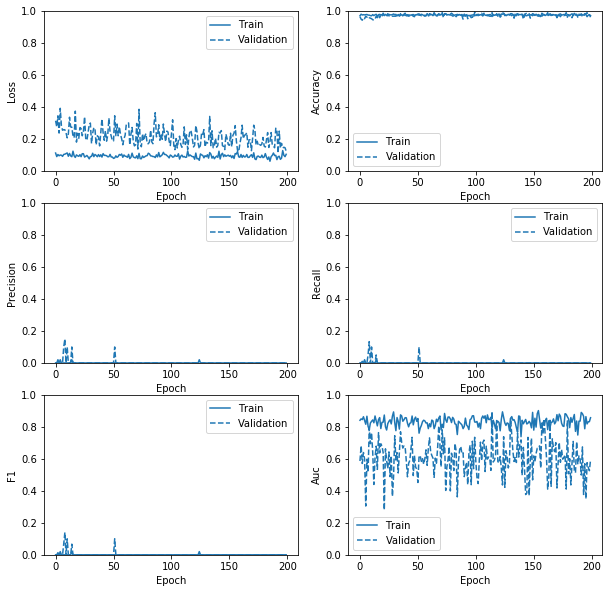

In [33]:
plt.figure(figsize=(10,10))
plot_metrics(imb_history)

## Evaluation

In [34]:
results_tr = model.evaluate(imb_train_generator,steps=100)
results_vl = model.evaluate(validation_generator,steps=100)

100/100 [==============================] - 19s 186ms/step


In [35]:
print("NAME :\tTRAIN :\tVALIDATION ")
for name, value_tr, value_vl in zip(model.metrics_names, results_tr, results_vl):
    print("%s : %5.3f : %7.3f" %(name, value_tr , value_vl))

# without classweights:
# NAME :	TRAIN :	VALIDATION 
# loss : 0.754 :   0.465
# Accuracy : 0.531 :   0.866
# Precision : 0.006 :   0.006
# Recall : 0.070 :   0.040
# F1 : 0.011 :   0.010
# AUC : 0.565 :   0.544

NAME :	TRAIN :	VALIDATION 
loss : 0.177 :   0.146
Accuracy : 0.981 :   0.977
Precision : 0.000 :   0.000
Recall : 0.000 :   0.000
F1 : 0.000 :   0.000
AUC : 0.538 :   0.622


## Prediction
The output of a binary classification is the probability of a sample belonging to a class.

In [36]:
# PREDICTED LABELS
start = time.time()
pred_tr = model.predict(imb_train_generator)
tr_end = time.time()
pred_vl = model.predict(validation_generator)
vl_end = time.time()

tr_end-start , vl_end-tr_end

(1065.1592907905579, 175.40238547325134)

In [37]:
# np.save(funduspath_CR + str(n_epochs) + 'ep_traintwice_newtr.npy', pred_tr)
# np.save(funduspath_CR + str(n_epochs) + 'ep_traintwice_newvl.npy', pred_vl)

In [38]:
# val_class = []
# for i, predicted in enumerate(pred_vl):
#     if predicted[0] > 0.1:
#         #assign i to class 1
#         val_class.append(1)
#     else:
#         #assign i to class 0
#         val_class.append(0)

In [39]:
# TRUE LABELS

train_labels = valid_traindf_names[Class].tolist()
train_labels = [int(i) for i in train_labels]

val_labels = valid_valdf_names[Class].tolist()
val_labels = [int(i) for i in val_labels]


### ROC Curve

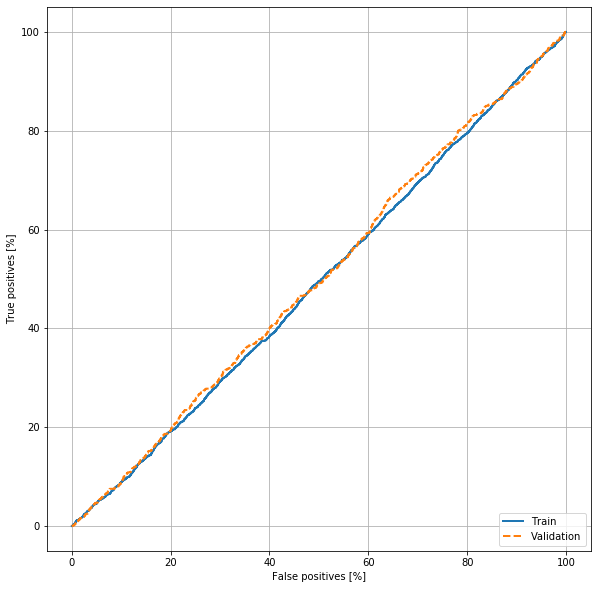

In [40]:
plt.figure(figsize=(10,10))
plot_roc("Train", train_labels, pred_tr, color=colors[0])
plot_roc("Validation", val_labels, pred_vl, color=colors[1],linestyle='--')
# plot_roc("Validation", val_labels, val_class, color=colors[3],linestyle='-.') # theshold 0.1
plt.legend(loc='lower right')

### Confusion matrix

Train data: 
TN: 99443 
FP: 12 
FN: 2379 
TP: 0
Healthy Patients - correctly identified (True Negatives):  99443 0.9998793424161682
Healthy Patients - predicted to have glaucoma (False Positives):  12 0.00012065758383188376
Glaucoma Patients - predicted healthy (False Negatives):  2379 1.0
Glaucoma Patients - correctly identified (True Positives):  0 0.0

Total Glaucoma patients:  2379 1.0
Total Healthy patients:  99455 1.0


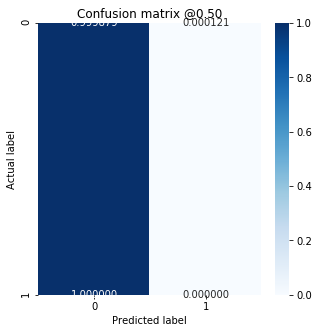

In [41]:
tn, fp, fn, tp = confusion_matrix(train_labels, pred_tr > 0.5).ravel()
train_cm = [tn, fp, fn, tp]
print("Train data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(train_labels, pred_tr)

Validation data: 
TN: 33124 
FP: 10 
FN: 809 
TP: 0
Healthy Patients - correctly identified (True Negatives):  33124 0.9996981952073399
Healthy Patients - predicted to have glaucoma (False Positives):  10 0.00030180479266010745
Glaucoma Patients - predicted healthy (False Negatives):  809 1.0
Glaucoma Patients - correctly identified (True Positives):  0 0.0

Total Glaucoma patients:  809 1.0
Total Healthy patients:  33134 1.0


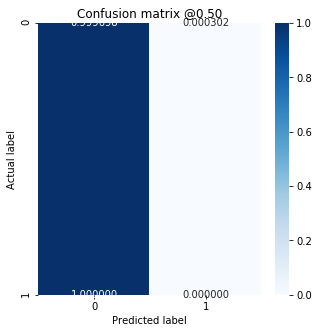

In [42]:
tn, fp, fn, tp = confusion_matrix(val_labels, pred_vl > 0.5).ravel()
val_cm = [tn, fp, fn, tp]
print("Validation data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(val_labels, pred_vl)

### MLFlow 

In [51]:
history = up3_history
tag_value = "trained twice bal and 1:20 and 1:40 with 78 tr layers with cw 0.5:3 and 0.2:5"

exp_name = get_notebook_name()+"-run at-"+datetime.datetime.now().strftime("%d%b%Y %H:%M")
keras_model_path = funduspath_CR+ exp_name + '_model'
save_mlflow(keras_model_path,exp_name,which_gt,which_model,seq,BATCH_SIZE,
            n_epochs,n_steps_per_epoch,n_validation_steps,
            reg_value,learning_rate,decay,opt,
            history,results_tr,results_vl,train_cm,val_cm
           )

<IPython.core.display.Javascript object>

In [52]:
client = MlflowClient()
run = client.create_run('21')
client.set_tag(run.info.run_id, "tag_key", tag_value)